In [1]:
import torch
import pandas as pd
import numpy as np
import sklearn
from collections import Counter

In [2]:
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
from itertools import combinations

In [4]:
import re
import os

In [5]:
import torch.nn as nn

In [6]:
import matplotlib.pyplot as plt

# Data Loading

In [7]:
path = "data/twitter.csv"
df = pd.read_csv(path, index_col=0)
df = df.rename(columns={'class': 'label'})
df.head()

,count,hate_speech,offensive_language,neither,label,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
path = 'data/all_movies.csv'
movie_data = pd.read_csv(path, index_col=0)

In [9]:
movie_data.head()

,movie_name,index,utterance,count_utterances,tag
0,12 Angry Men,0,"Thank you very much, sir.",2065,racism
1,12 Angry Men,1,You did a wonderful job. Wonderful.,2065,racism
2,12 Angry Men,2,Shh. Shh.,2065,racism
3,12 Angry Men,3,"We did it, Pete. We did it.",2065,racism
4,12 Angry Men,4,"For a moment, we had our doubts.",2065,racism


1    19190
2     4163
0     1430
Name: label, dtype: int64


array([<AxesSubplot:ylabel='label'>], dtype=object)

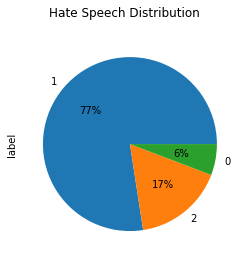

In [10]:
print(df.label.value_counts())
df.label.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Hate Speech Distribution')

## Data Cleansing

In [11]:
def filter_hatespeech_tweets(df):
    
    def filter_tweets(tweet):
        tweet = re.sub('@.\:|!|@\w+|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', tweet)
        if tweet[0:4] == '  : ':
            tweet = tweet[4:]
        return tweet

    df['tweet'] = df['tweet'].apply(filter_tweets)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    return df

In [12]:
df = filter_hatespeech_tweets(df)
df = filter_hatespeech_tweets(df)

In [13]:
df.head()

,count,hate_speech,offensive_language,neither,label,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,Dawg : You ever fuck a bitch and she start...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...


## Data Splitting

In [14]:
def split_dataset(df, seed, test_size):
    train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    return train.tweet.values, train.label.values, test.tweet.values, test.label.values

In [15]:
#categories = ['hate speech', 'offensive language', 'neither']
categories = [0,1,2]
seed = 11
test_size = 0.2

In [16]:
train, train_targets, test, test_targets = split_dataset(df, seed=seed, test_size=test_size)

In [17]:
train_size = len(train)
test_size = len(test)

In [18]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]], [s.index[2], s[2]]

In [19]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [20]:
train_ds = Bunch(data=train, target=train_targets)
test_ds = Bunch(data=test, target=test_targets)

## Buidling the Model

In [21]:
# Getting all the vocabularies and indexing to a unique position
vocab = Counter()
#Indexing words from the training data
for text in train_ds.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

#Indexing words from the training data
for text in test_ds.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

for text in movie_data.utterance.values:
    for word in text.split(' '):
        vocab[word.lower()]+=1
        
total_words = len(vocab)

def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i

    return word2index

word2index = get_word_2_index(vocab)

In [22]:
print(len(word2index))
print(word2index["the"]) # Showing the index of 'the'
print (total_words)

128056
137
128056


In [23]:
# define the network
class News_20_Net(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(News_20_Net, self).__init__()
        self.layer_1 = nn.Linear(input_size,hidden_size, bias=True).cuda()
        self.relu = nn.ReLU().cuda()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True).cuda()
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True).cuda()
    # accept input and return an output
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [24]:
def get_batch(df,i,batch_size):
    batches = []
    results = []
    # Split into different batchs, get the next batch 
    texts = df.data[i*batch_size:i*batch_size+batch_size]
    # get the targets 
    categories = df.target[i*batch_size:i*batch_size+batch_size]
    #print(categories)
    for text in texts:
        # Dimension, 196609
        layer = np.zeros(total_words,dtype=float)

        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1
        batches.append(layer)

    # We have 5 categories
    for category in categories:
        #print(category)
        index_y = -1
        if category == 0:
            index_y = 0
        elif category == 1:
            index_y = 1
        elif category == 2:
            index_y = 2
        results.append(index_y)

    # the training and the targets
    return np.array(batches),np.array(results)

In [25]:
# Parameters
learning_rate = 0.001
num_epochs = 8
batch_size = 32
display_step = 10 # ADDED will multiplied by 10

# Network Parameters
hidden_size = 100      # 1st layer and 2nd layer number of features
input_size = total_words # Words in vocab
num_classes = len(categories)         # Categories: "graphics","space","baseball","guns", "christian"

## Training

In [26]:
results = []

In [27]:
news_net = News_20_Net(input_size, hidden_size, num_classes)
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # This includes the Softmax loss function
optimizer = torch.optim.Adam(news_net.parameters(), lr=learning_rate)  

# Train the Model
for epoch in range(num_epochs):
    # determine the number of min-batches based on the batch size and size of training data
    total_batch = int(len(train_ds.data)/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_ds,i,batch_size)
        
        articles = torch.cuda.FloatTensor(batch_x, device='cuda')
        labels = torch.cuda.LongTensor(batch_y, device='cuda')

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = news_net(articles)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % display_step == 0:
            result = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f'%(epoch+1, num_epochs, i+1, len(train_ds.data)/batch_size, loss.data)
            results.append({'Epoch': epoch+1, 'Step': i+1, 'Loss': loss.data.item()})
            if (i+1) % (display_step*10) == 0:
                print({'Epoch': epoch+1, 'Step': i+1, 'Loss': loss.data.item()})

{'Epoch': 1, 'Step': 100, 'Loss': 0.39721137285232544}
{'Epoch': 1, 'Step': 200, 'Loss': 0.6247244477272034}
{'Epoch': 1, 'Step': 300, 'Loss': 0.4863812029361725}
{'Epoch': 1, 'Step': 400, 'Loss': 0.5373004674911499}
{'Epoch': 1, 'Step': 500, 'Loss': 0.4418475925922394}
{'Epoch': 1, 'Step': 600, 'Loss': 0.29294759035110474}
{'Epoch': 2, 'Step': 100, 'Loss': 0.16304244101047516}
{'Epoch': 2, 'Step': 200, 'Loss': 0.4130038321018219}
{'Epoch': 2, 'Step': 300, 'Loss': 0.20423699915409088}
{'Epoch': 2, 'Step': 400, 'Loss': 0.28104493021965027}
{'Epoch': 2, 'Step': 500, 'Loss': 0.381056547164917}
{'Epoch': 2, 'Step': 600, 'Loss': 0.06039911508560181}
{'Epoch': 3, 'Step': 100, 'Loss': 0.07431770116090775}
{'Epoch': 3, 'Step': 200, 'Loss': 0.36535996198654175}
{'Epoch': 3, 'Step': 300, 'Loss': 0.06036044657230377}
{'Epoch': 3, 'Step': 400, 'Loss': 0.05169132351875305}
{'Epoch': 3, 'Step': 500, 'Loss': 0.18940408527851105}
{'Epoch': 3, 'Step': 600, 'Loss': 0.039312783628702164}
{'Epoch': 4, 'St

## Validation

In [28]:
# Test the Model
correct = 0
total = 0
total_test_data = len(test_ds.target)

In [29]:
iterates = total_test_data/batch_size # ignore last (<batch_size) batch

In [30]:
all_total = []
all_correct = []
labels_all = []
predicted_all = []

In [31]:
for i in range(int(iterates)):
    batch_x_test,batch_y_test = get_batch(test_ds,i,batch_size)
    articles = torch.FloatTensor(batch_x_test).to('cuda')
    labels = torch.LongTensor(batch_y_test).to('cuda')
    outputs = news_net(articles)
    _, predicted = torch.max(outputs.data, 1)
    
    labels_all.extend([x.item() for x in labels])
    predicted_all.extend([x.item() for x in predicted])

In [32]:
categories = ['hate speech', 'offensive language', 'neither']

In [33]:
report = classification_report(labels_all, predicted_all, target_names=categories, output_dict=True)

In [34]:
df_report = pd.DataFrame(report).transpose()

In [35]:
df_report

,precision,recall,f1-score,support
hate speech,0.435028,0.256667,0.322851,300.000000
offensive language,0.907125,0.931539,0.919170,3827.000000
neither,0.755177,0.774032,0.764488,801.000000
accuracy,0.864854,0.864854,0.864854,0.864854
macro avg,0.699110,0.654079,0.668836,4928.000000
weighted avg,0.853687,0.864854,0.857726,4928.000000


In [36]:
df_results = pd.DataFrame(results)

In [37]:
df_results['learning_rate'] = learning_rate
df_results['num_epochs'] = num_epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] = num_classes
df_results['test_size'] = test_size
df_results['train_size'] = train_size
df_results['seed'] = seed
df_results['test_size'] = test_size
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['train_class_proportion_' + categories[2]] = round(train_class_distribution[2][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[2]] = round(test_class_distribution[2][1], 2)

In [38]:
df_results.head()

,Epoch,Step,Loss,learning_rate,num_epochs,batch_size,num_classes,test_size,train_size,seed,train_class_proportion_hate speech,train_class_proportion_offensive language,train_class_proportion_neither,test_class_proportion_hate speech,test_class_proportion_offensive language,test_class_proportion_neither
0,1,10,1.007312,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
1,1,20,0.786021,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
2,1,30,0.681137,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
3,1,40,0.638749,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16
4,1,50,0.738855,0.001,8,32,3,4957,19825,11,0.06,0.77,0.17,0.06,0.78,0.16


In [39]:
name = 'training_logs_word_embedding_twitter.csv'

In [40]:
df_results.to_csv(name)

In [41]:
name = 'matrix_report_twitter.csv'

In [42]:
df_report.to_csv(name)

In [43]:
def plot_loss(path, ax, title):
    df = pd.read_csv(path)
    df.groupby('Epoch').Loss.plot(kind='line', legend=True, title=title, ax=ax, figsize=(15,8))
    ax.legend(loc='upper right')
    plt.xlabel('Step') 
    plt.ylabel('Loss')

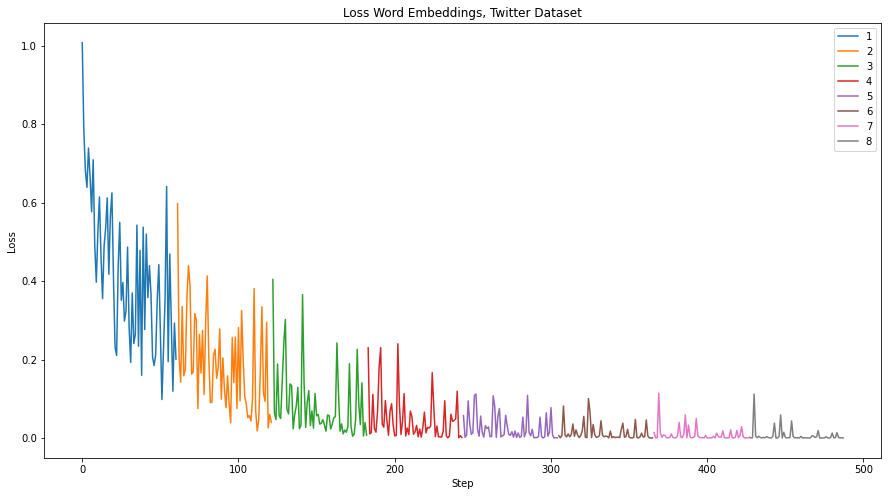

In [44]:
fig, axs = plt.subplots(1,1)
path = './training_logs_word_embedding_twitter.csv'
plot_loss(path, axs, title='Loss Word Embeddings, Twitter Dataset')

----

## Classication of Movies

### Load Movies

In [45]:
def read_movie_files(pathes):
    result = []
    for path in pathes: 
        directory = os.fsencode(path)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)

            if filename.endswith(".csv"):
                #print(os.path.join(directory, filename))
                #local_df = read_content(path + '//' + filename)
                movie_df = pd.read_csv(path + '//' + filename)
                tag = path.split('/')[1]
                count_utterances = movie_df.shape[0]
                result.append({'movie_name': filename[:-9], 'count_utterances': count_utterances, 'tag': tag, 'path': path + '//' + filename})
    result_df = pd.DataFrame(result)
    return result_df

In [46]:
pathes = ['movies/racism', 'movies/hate_speech', 'movies/friendship']

In [47]:
movie_metadata_df = read_movie_files(pathes)

In [48]:
movie_metadata_df.head()

,movie_name,count_utterances,tag,path
0,12 Angry Men,2065,racism,movies/racism//12 Angry Men_conv.csv
1,12 Years a Slave,110,racism,movies/racism//12 Years a Slave_conv.csv
2,42,1288,racism,movies/racism//42_conv.csv
3,A Bronx Tale,1961,racism,movies/racism//A Bronx Tale_conv.csv
4,A Time to Kill,2219,racism,movies/racism//A Time to Kill_conv.csv


array([<AxesSubplot:ylabel='tag'>], dtype=object)

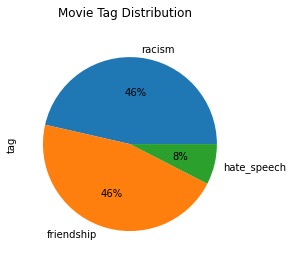

In [49]:
movie_metadata_df.tag.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Movie Tag Distribution')

In [50]:
movie_path = 'movies/racism/12 Years a Slave_conv.csv'

In [51]:
def annotate_single_movie(movie_df):
    utterances = movie_df.dialog.values
    predictions = []
    batch = []
    
    for text in utterances:
        # Dimension, 196609
        layer = np.zeros(total_words,dtype=float)

        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1

        batch.append(layer)
        
    texts = torch.FloatTensor(batch).to('cuda')
    outputs = news_net(texts)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend([x.item() for x in predicted])

    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_word_embedding_twitter': categories[pred]})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    del movie_df['Unnamed: 0']
    del movie_df['index']
    
    return movie_df

## Annotate Movies

In [1]:
def movie_data_cleansing(df):
    df = df.replace(r'\\... ', '', regex=True)
    df = df.replace(r'<.*?>', '', regex=True)
    return df

In [53]:
movie_df = pd.read_csv('movies/racism/12 Angry Men_conv.csv')

In [54]:
movie_df.head()

,Unnamed: 0,dialog
0,0,"Thank you very much, sir."
1,1,You did a wonderful job. Wonderful.
2,2,Shh. Shh.
3,3,"We did it, Pete. We did it."
4,4,"For a moment, we had our doubts."


In [55]:
annotate_single_movie(movie_df)

,dialog,label_word_embedding_twitter
0,"Thank you very much, sir.",neither
1,You did a wonderful job. Wonderful.,neither
2,Shh. Shh.,offensive language
3,"We did it, Pete. We did it.",neither
4,"For a moment, we had our doubts.",neither
...,...,...
2060,What's your name?,offensive language
2061,Davis.,neither
2062,My name's McCardle.,offensive language
2063,"Well, so long.",offensive language


In [56]:
def annotate_movies(movie_metadata_df):
    
    pathes = movie_metadata_df.path.values
    tags = movie_metadata_df.tag.values
    movie_names = movie_metadata_df.movie_name.values
    
    result = []
    for i in range(0, movie_metadata_df.shape[0]):
        path = pathes[i]
        tag = tags[i]
        movie_name = movie_names[i]
        print(i+1, movie_metadata_df.shape[0], path, tag, movie_name)
        movie_df = pd.read_csv(path)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = annotate_single_movie(movie_df)
        
        labels = movie_df.label_word_embedding_twitter.values
                
        for i in range(0, len(labels)):
            result.append({'movie_name': movie_name, 'index': i, 'label': labels[i]})
                    
    result_df = pd.DataFrame(result)     
    return result_df

In [57]:
movies_annotated_df = annotate_movies(movie_metadata_df)

movies/racism//12 Angry Men_conv.csv racism 12 Angry Men
movies/racism//12 Years a Slave_conv.csv racism 12 Years a Slave
movies/racism//42_conv.csv racism 42
movies/racism//A Bronx Tale_conv.csv racism A Bronx Tale
movies/racism//A Time to Kill_conv.csv racism A Time to Kill
movies/racism//AI Artificial Intelligence_conv.csv racism AI Artificial Intelligence
movies/racism//American History X_conv.csv racism American History X
movies/racism//Amistad_conv.csv racism Amistad
movies/racism//Angel Heart_conv.csv racism Angel Heart
movies/racism//Antebellum_conv.csv racism Antebellum
movies/racism//Apocalypse Now_conv.csv racism Apocalypse Now
movies/racism//Bad Boys II_conv.csv racism Bad Boys II
movies/racism//Bend It Like Beckham_conv.csv racism Bend It Like Beckham
movies/racism//Blood Father_conv.csv racism Blood Father
movies/racism//Bone Tomahawk_conv.csv racism Bone Tomahawk
movies/racism//Boyz n the Hood_conv.csv racism Boyz n the Hood
movies/racism//Bright_conv.csv racism Bright
m

In [58]:
movies_annotated_df.to_csv('annotations_word_embedding_twitter.csv')